In [14]:

import matplotlib.pyplot as plt
import cv2
import numpy as np

In [20]:
def equalize_histogram(image: np.ndarray) -> np.ndarray:
    if len(image.shape) > 2 and image.shape[2] == 3:
        ycrcb_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        
        y, cr, cb = cv2.split(ycrcb_image)
        
        y_equalized = cv2.equalizeHist(y)
        
        equalized_ycrcb = cv2.merge([y_equalized, cr, cb])
        
        equalized_image = cv2.cvtColor(equalized_ycrcb, cv2.COLOR_YCrCb2BGR)
        
        return equalized_image
    else:
        return cv2.equalizeHist(image)

In [21]:
def plot_hist_normalized(image: np.ndarray):
    equalized_image = equalize_histogram(image)
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))
    
    ax[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[0, 0].set_title('Imagem Original')
    ax[0, 0].axis('off')

    colors = ('b', 'g', 'r')
    ax[1, 0].set_title("Histograma Original (Canais BGR)")
    ax[1, 0].set_xlabel("Intensidade do Pixel")
    ax[1, 0].set_ylabel("Número de Pixels")
    for i, color in enumerate(colors):
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        ax[1, 0].plot(hist, color=color)
    ax[1, 0].set_xlim([0, 256])

    ax[0, 1].imshow(cv2.cvtColor(equalized_image, cv2.COLOR_BGR2RGB))
    ax[0, 1].set_title('Imagem Equalizada')
    ax[0, 1].axis('off')
    
    ax[1, 1].set_title("Histograma da Imagem Equalizada (Canais BGR)")
    ax[1, 1].set_xlabel("Intensidade do Pixel")
    for i, color in enumerate(colors):
        hist = cv2.calcHist([equalized_image], [i], None, [256], [0, 256])
        ax[1, 1].plot(hist, color=color)
    ax[1, 1].set_xlim([0, 256])
    
    plt.tight_layout()
    plt.show()


Criando o dataset com imagens equalizadas

In [ ]:
import os 
BASE_DIR = 'dataset'
IMAGE_DIR = os.path.join(BASE_DIR, 'images')
OUTPUT_DIR = os.path.join('normalized_dataset', 'images')
os.makedirs(OUTPUT_DIR, exist_ok=True)
images = os.listdir(IMAGE_DIR)
print(images)
for image_name in images:
    image_path = os.path.join(IMAGE_DIR, image_name)
    image = cv2.imread(image_path)
    output_path = os.path.join(OUTPUT_DIR, image_name)
    out_image = equalize_histogram(image)
    cv2.imwrite(output_path, out_image)

In [29]:
samples = os.listdir(IMAGE_DIR)[:5]
print(samples)

['1-02-V1-W.png', '9-01-V1-W.png', '3-02-V2-B.png', '7-03-V2-W.png', '2-05-V1-W.png']


Exemplos de imagens equalizadas

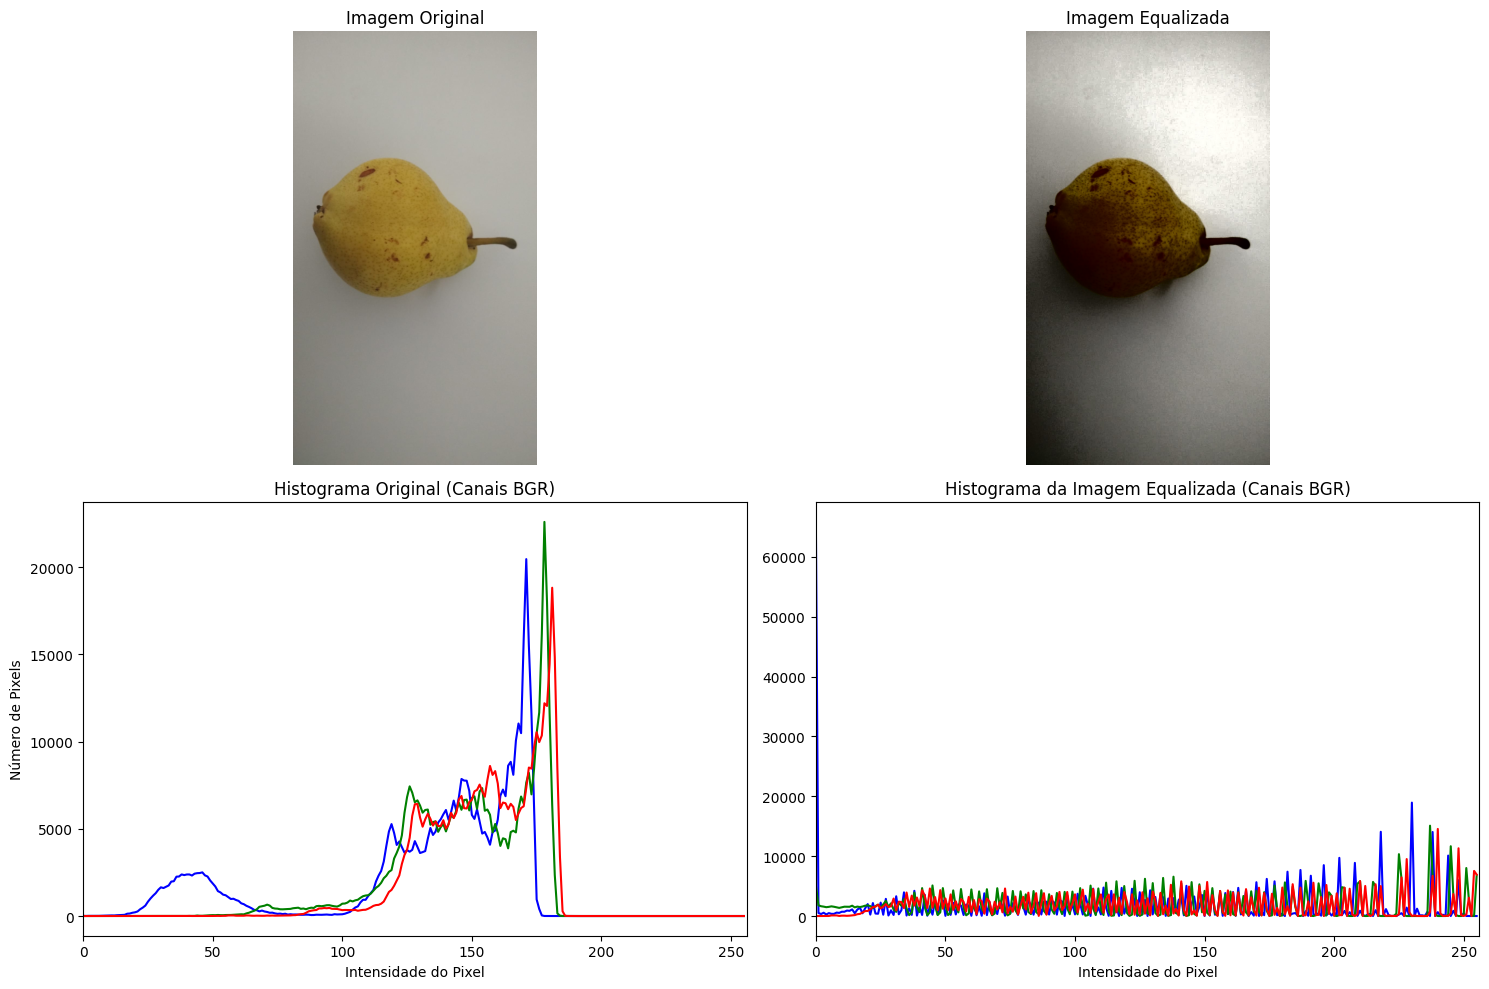

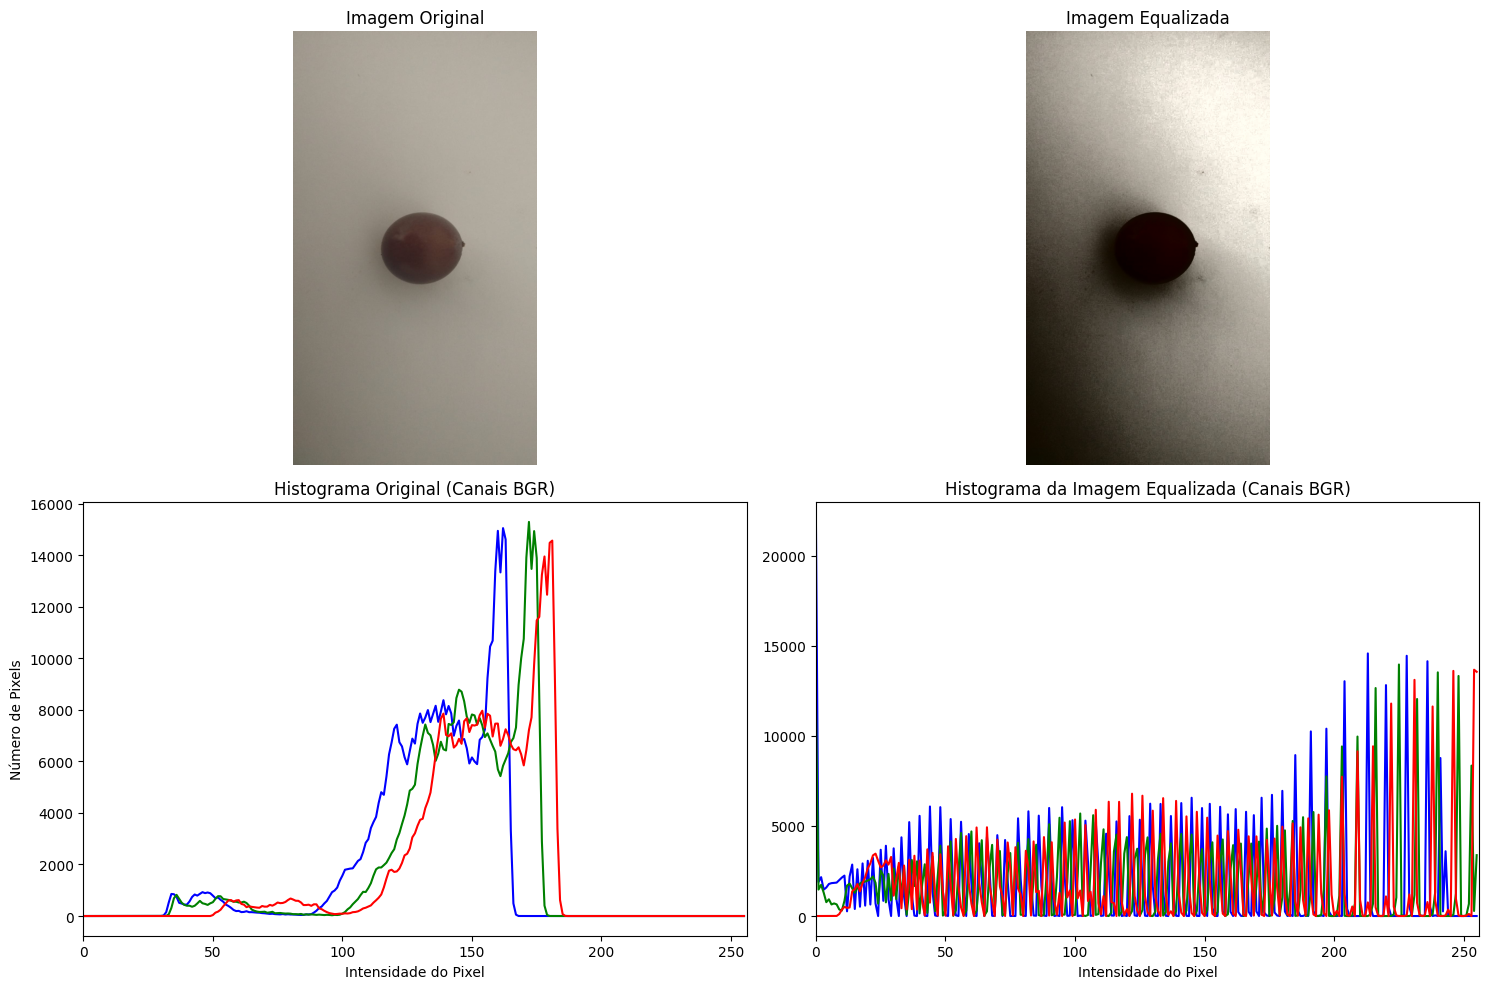

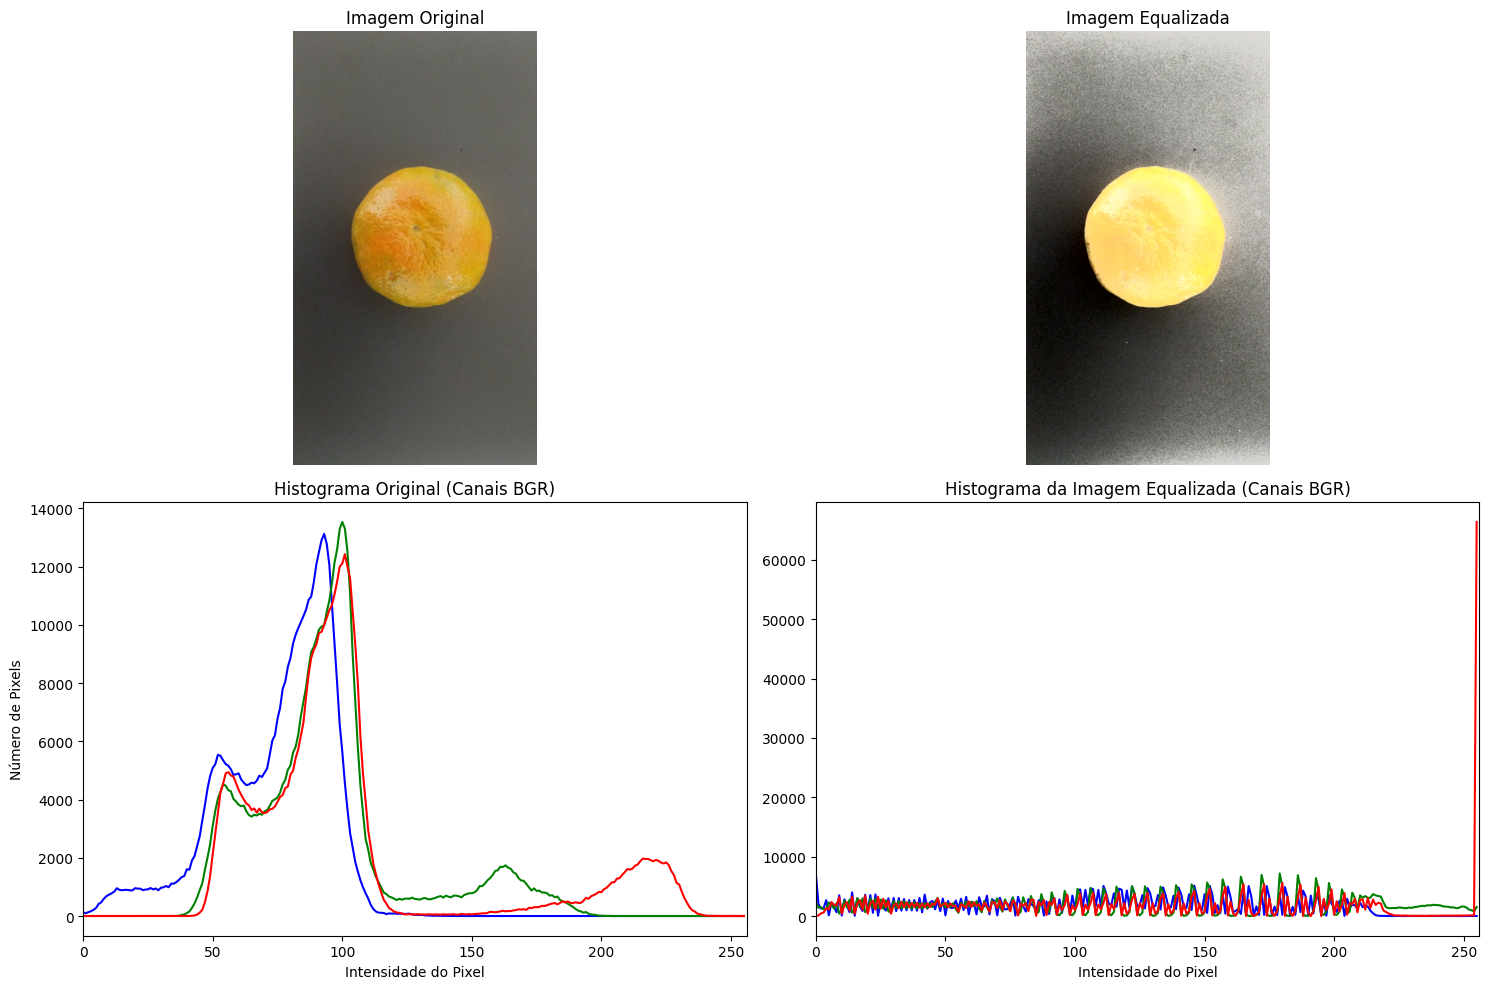

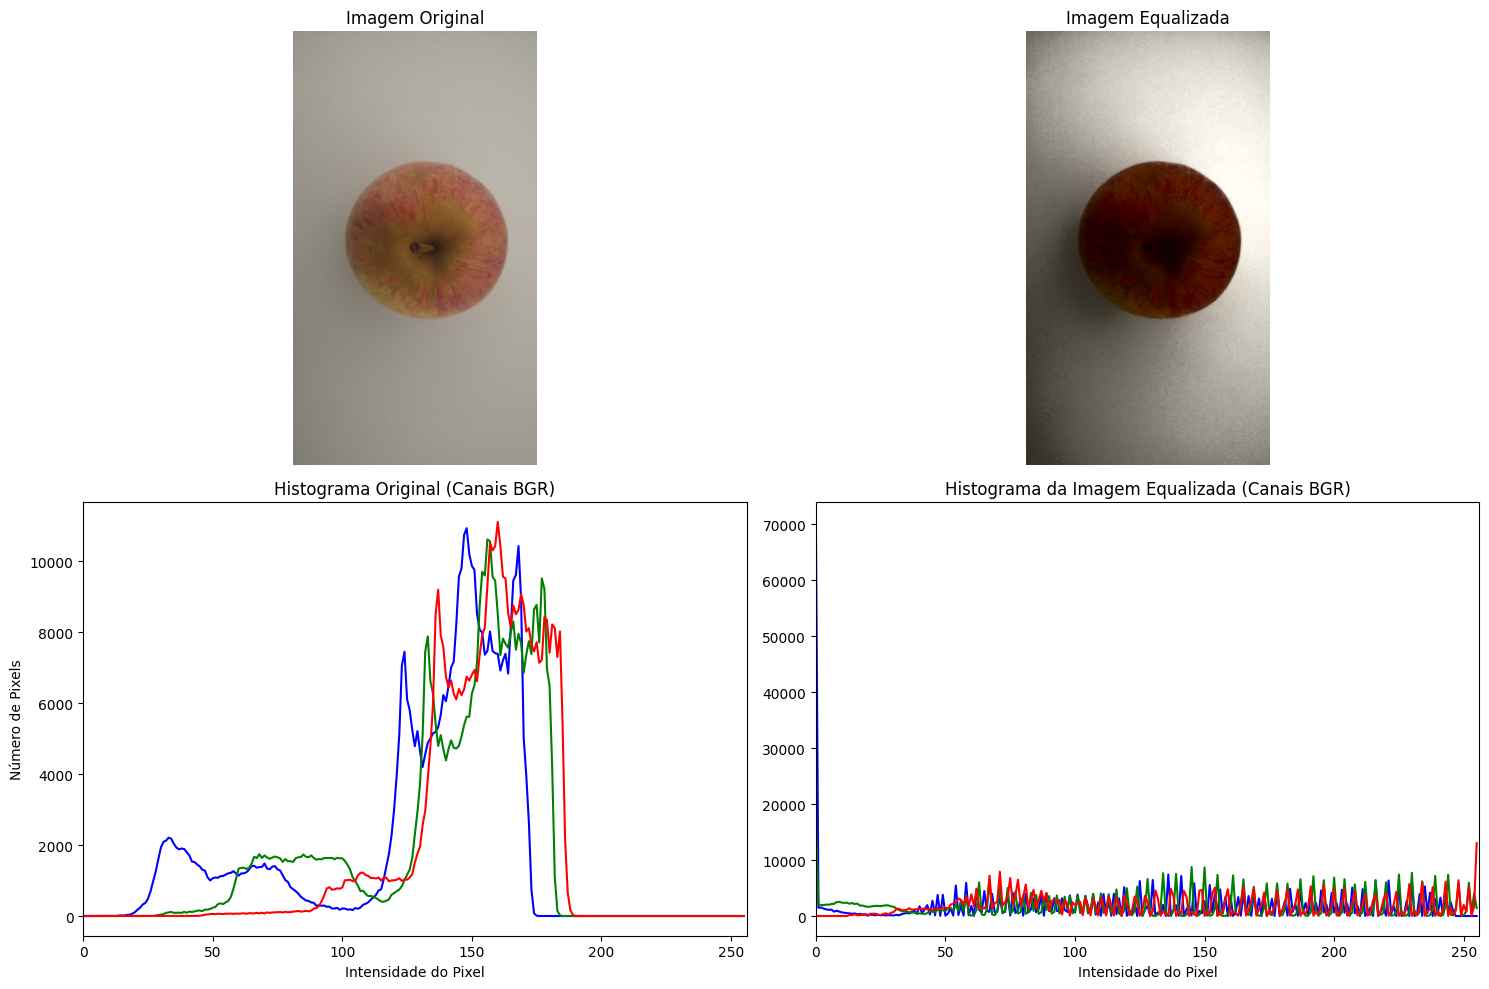

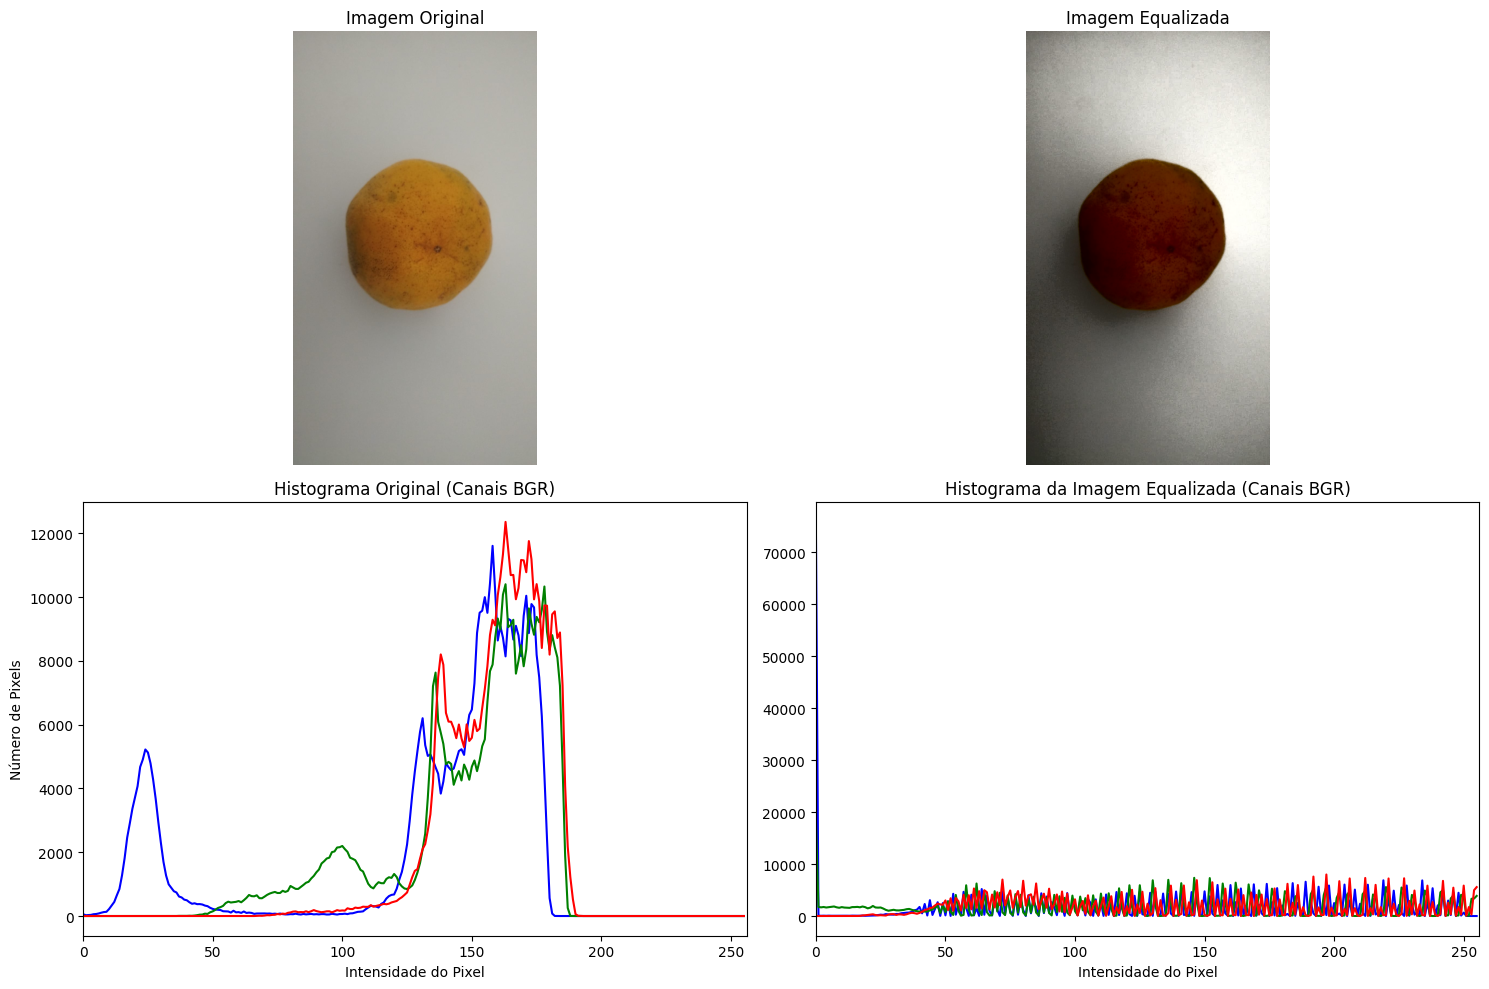

In [28]:
for sample in samples:
    image_path = os.path.join(IMAGE_DIR, sample)
    image = cv2.imread(image_path) 
    plot_hist_normalized(image)

In [34]:
PROTOTYPE_DIM = (910, 512)

In [35]:
def calculate_class_statistics(class_path: str, begin_id: str):
    image_files = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.startswith(begin_id) and f.endswith(('.png', '.jpg', '.jpeg'))]
    image_count = len(image_files)

    if image_count == 0:
        print(f"Nenhuma imagem encontrada em '{class_path}' com o prefixo '{begin_id}'.")
        return None, None, None

    # Lê a primeira imagem para obter as dimensões
    first_img = cv2.imread(image_files[0])
    if first_img is None:
        print(f"Erro ao ler a primeira imagem: {image_files[0]}")
        return None, None, None
    h, w, c = first_img.shape

    # Inicializa acumuladores para 3 canais (BGR)
    sum_prototype = np.zeros((h, w, c), dtype=np.float64)
    sum_hist = np.zeros((256, c), dtype=np.float64)
    sum_sq_hist = np.zeros((256, c), dtype=np.float64)

    for img_file in image_files:
        # Lê a imagem em cores (BGR)
        img = cv2.imread(img_file)
        if img is None or img.shape != (h, w, c):
            print(f"Aviso: Pulando imagem com formato inválido ou diferente: {img_file}")
            continue

        # Acumula para o protótipo médio
        sum_prototype += img.astype(np.float64)
        
        # Normaliza a imagem colorida
        normalized_img = equalize_histogram(img)
        
        # Calcula e acumula histogramas para cada canal B, G, R
        for i in range(c):
            hist = cv2.calcHist([normalized_img], [i], None, [256], [0, 256])
            sum_hist[:, i] += hist.flatten()
            sum_sq_hist[:, i] += (hist.flatten() ** 2)

    # Evita divisão por zero se todas as imagens foram puladas
    if np.sum(sum_prototype) == 0:
        image_count = 1 # Prevenção

    # Calcula as estatísticas finais
    mean_prototype = (sum_prototype / image_count).astype(np.uint8)
    mean_hist = sum_hist / image_count
    
    # Var(X) = E[X^2] - (E[X])^2
    mean_of_sq_hist = sum_sq_hist / image_count
    hist_variance = mean_of_sq_hist - (mean_hist ** 2)
    
    return mean_prototype, mean_hist, hist_variance

In [36]:
def plot_results(class_name: str, prototype: np.ndarray, mean_hist: np.ndarray, hist_variance: np.ndarray):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
    fig.suptitle(f'Estatísticas da Classe: {class_name}', fontsize=16)
    
    colors = ('blue', 'green', 'red')
    labels = ('Canal Azul', 'Canal Verde', 'Canal Vermelho')

    # 1. Protótipo Médio (Colorido)
    # Converte de BGR (OpenCV) para RGB (Matplotlib)
    ax1.imshow(cv2.cvtColor(prototype, cv2.COLOR_BGR2RGB))
    ax1.set_title("Protótipo Médio")
    ax1.axis('off')

    # 2. Histograma Médio (3 canais)
    ax2.set_title("Histograma Médio")
    for i in range(mean_hist.shape[1]):
        ax2.plot(mean_hist[:, i], color=colors[i], label=labels[i])
    ax2.set_xlim([0, 256])
    ax2.set_xlabel("Intensidade do Pixel")
    ax2.set_ylabel("Frequência Média")
    ax2.legend()

    # 3. Variância do Histograma (3 canais)
    ax3.set_title("Variância do Histograma")
    for i in range(hist_variance.shape[1]):
        ax3.plot(hist_variance[:, i], color=colors[i], label=labels[i])
    ax3.set_xlim([0, 256])
    ax3.set_xlabel("Intensidade do Pixel")
    ax3.set_ylabel("Variância")
    ax3.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

Estastísticas do dataset com histograma normalizado

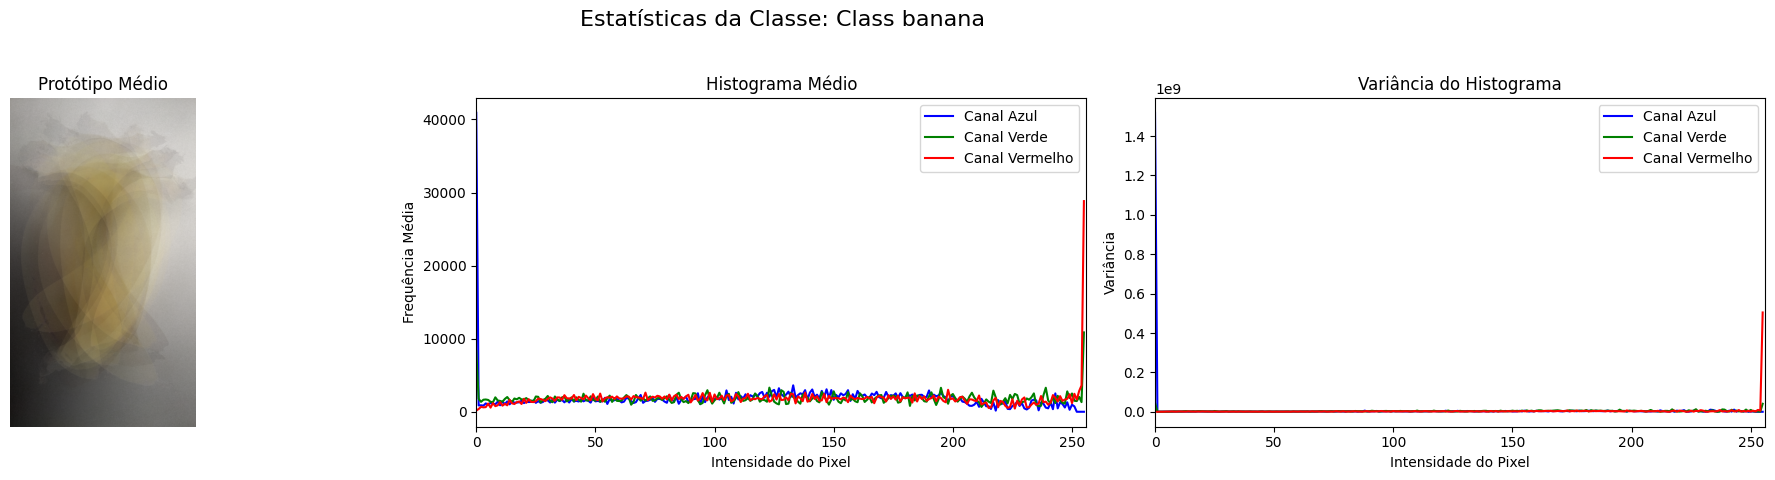

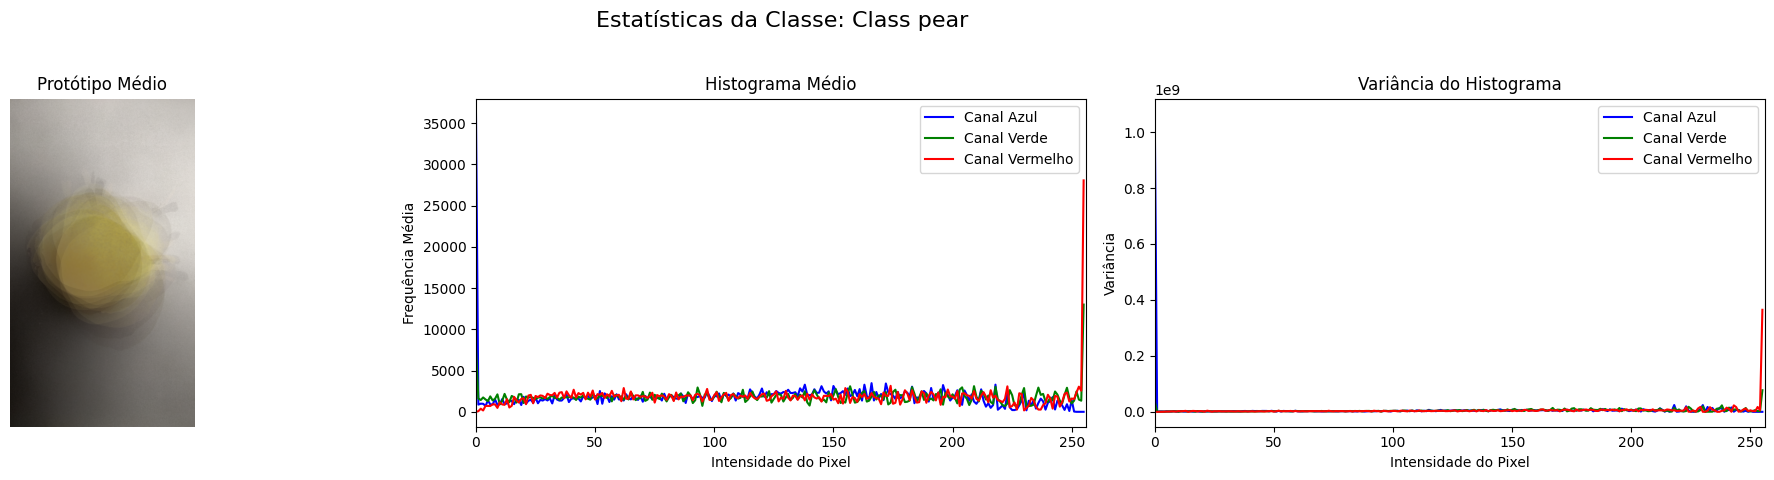

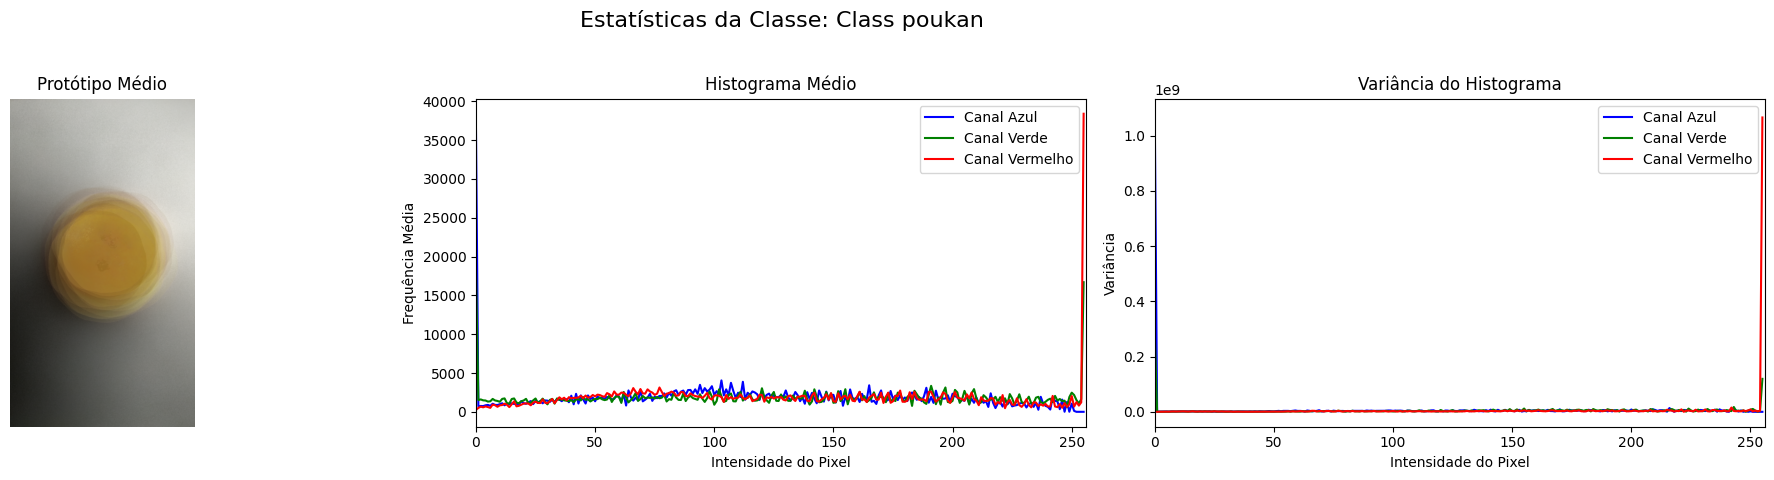

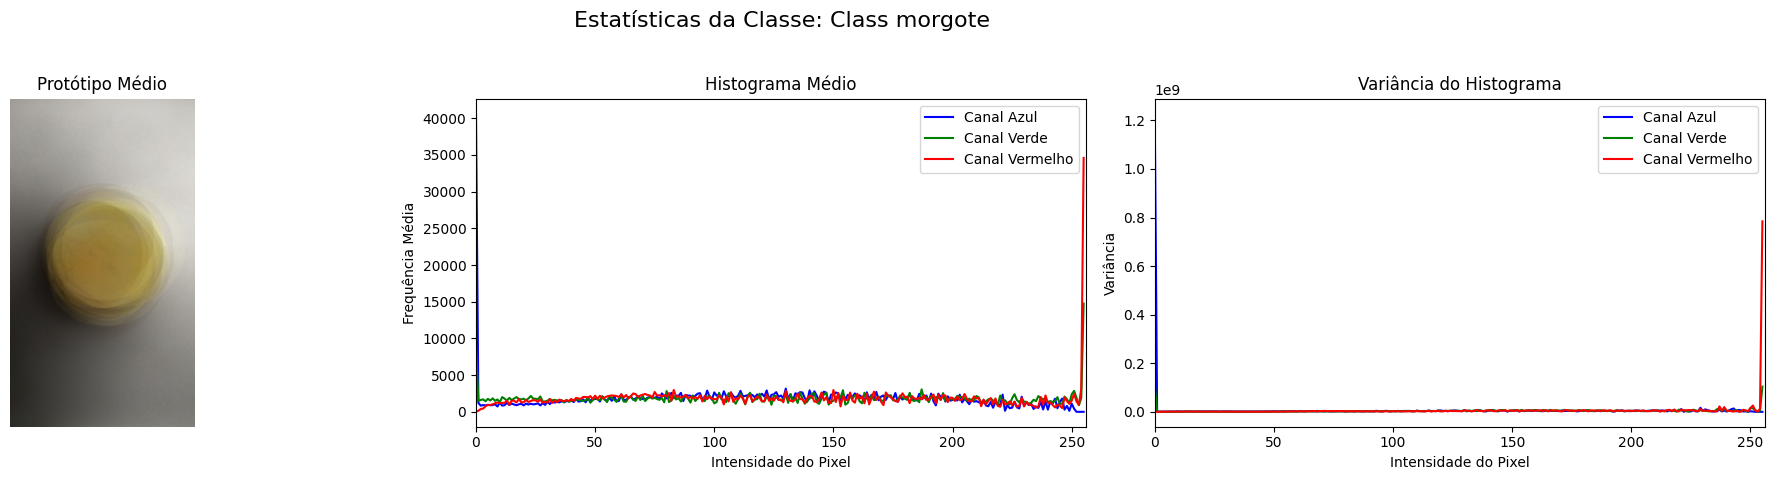

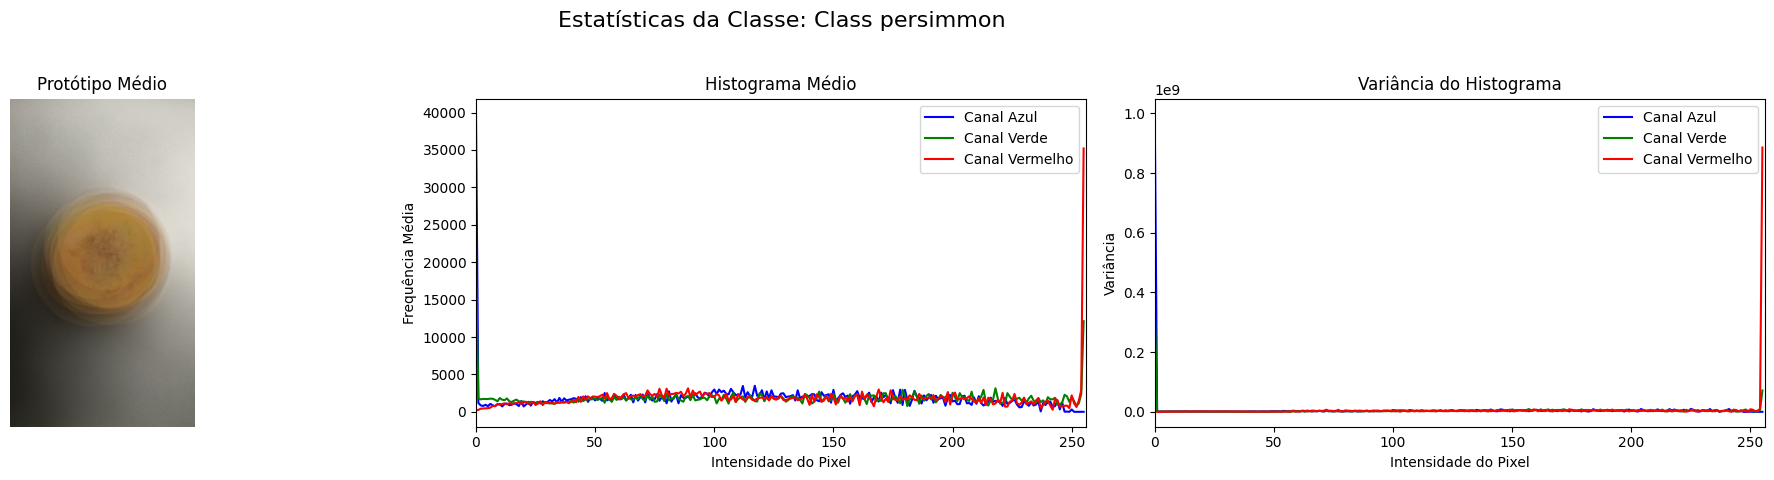

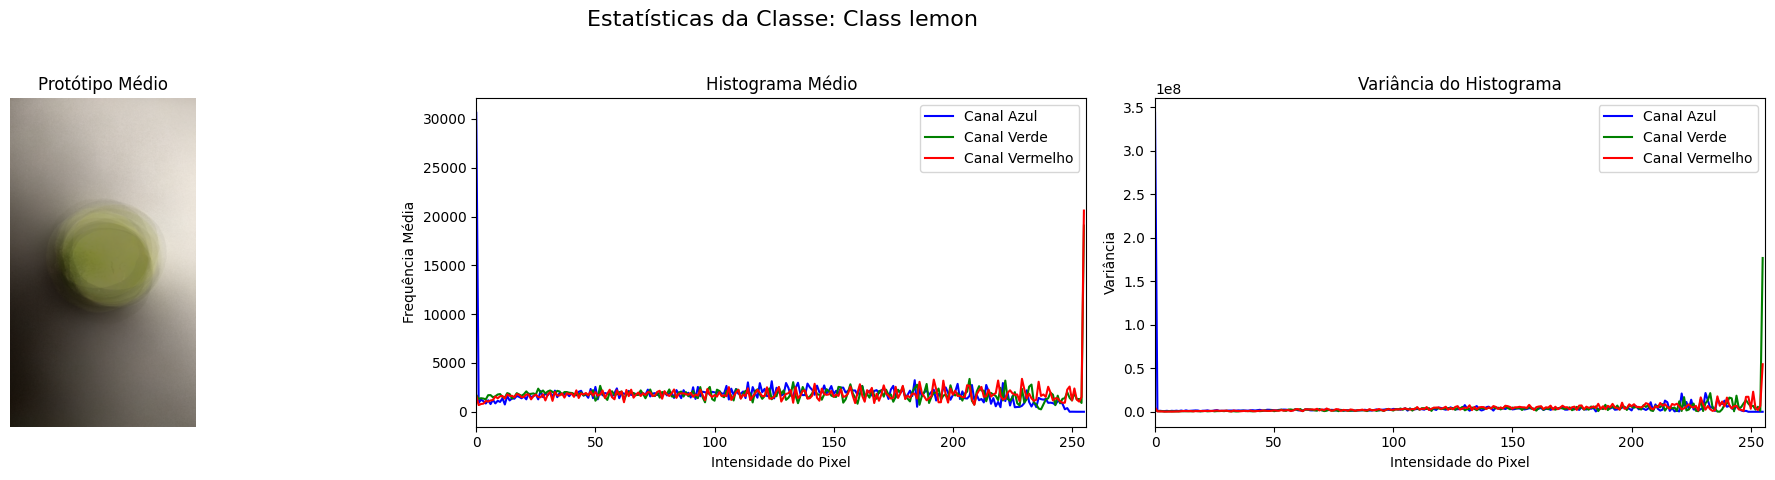

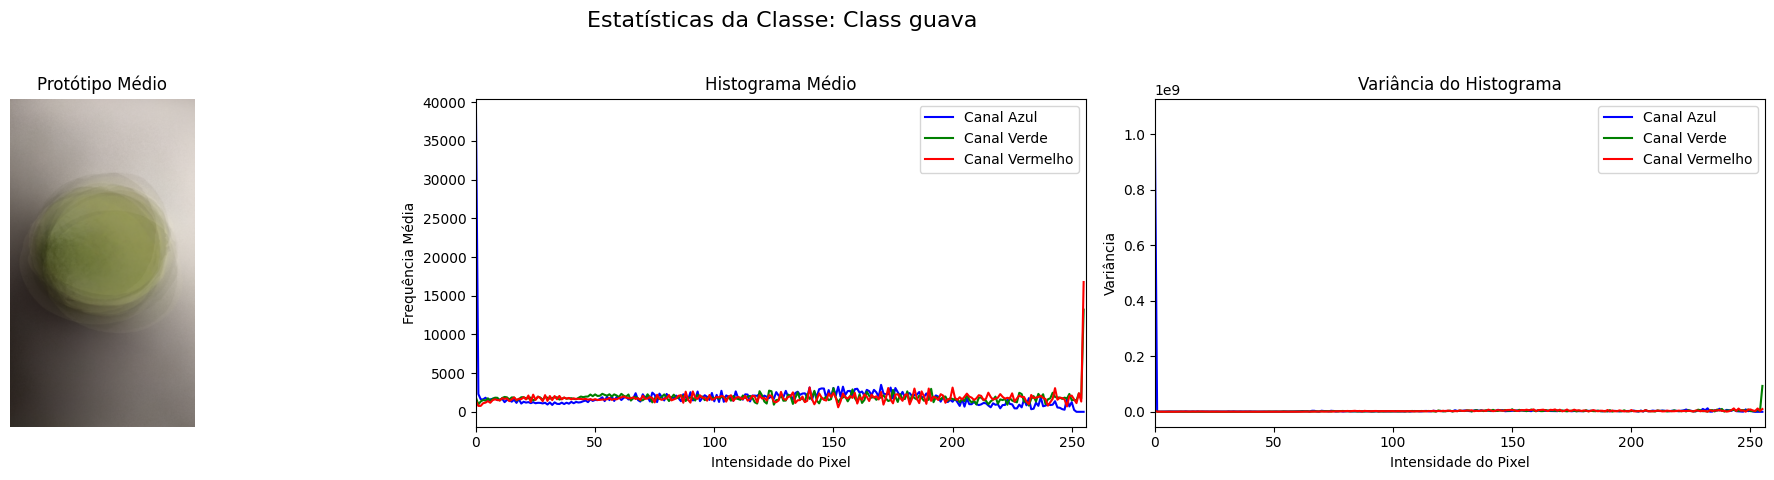

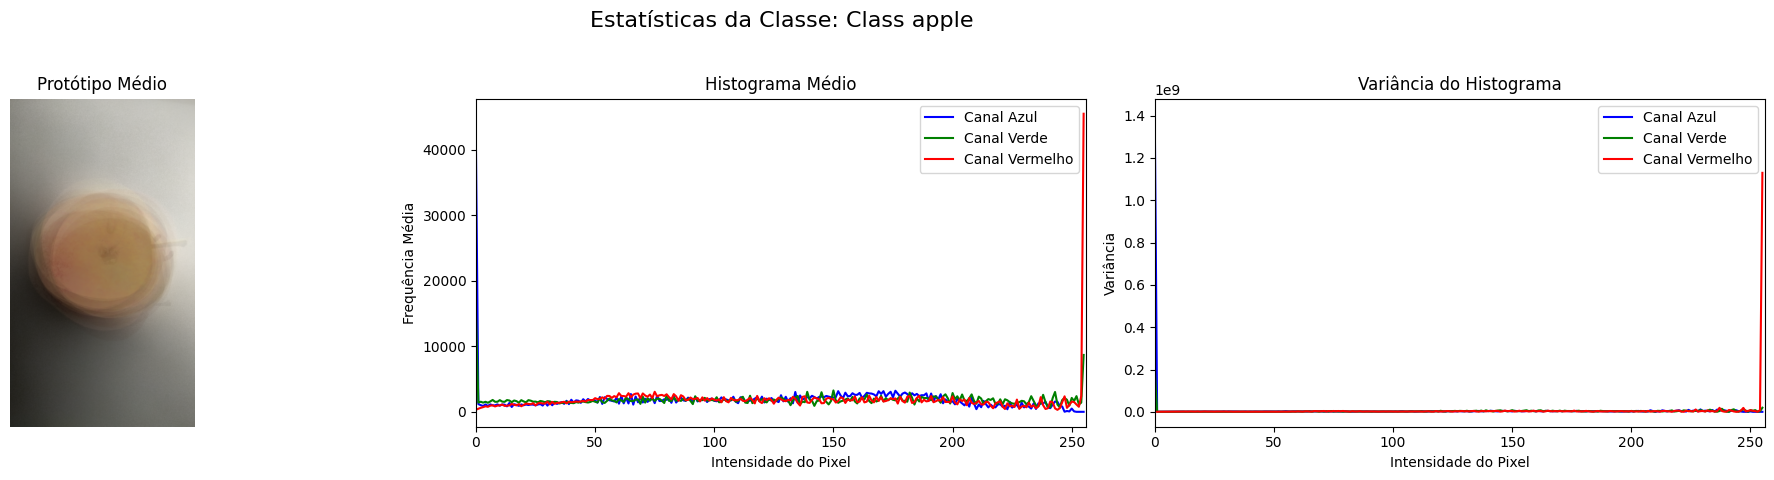

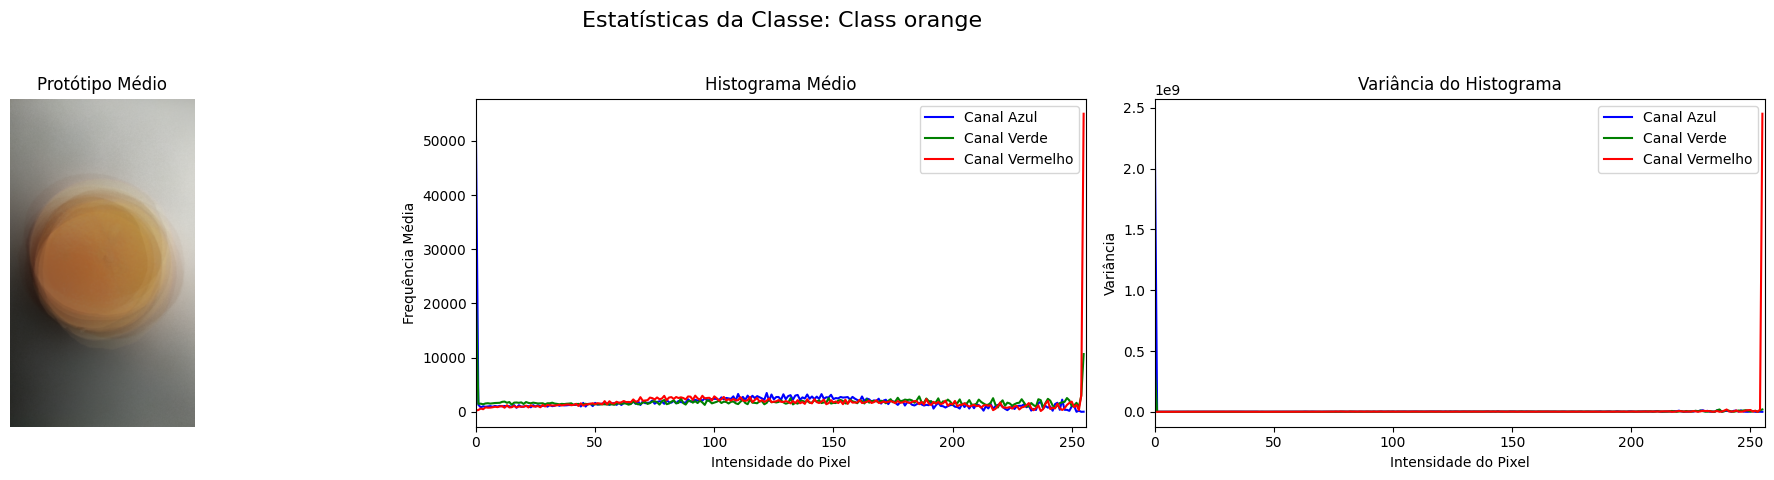

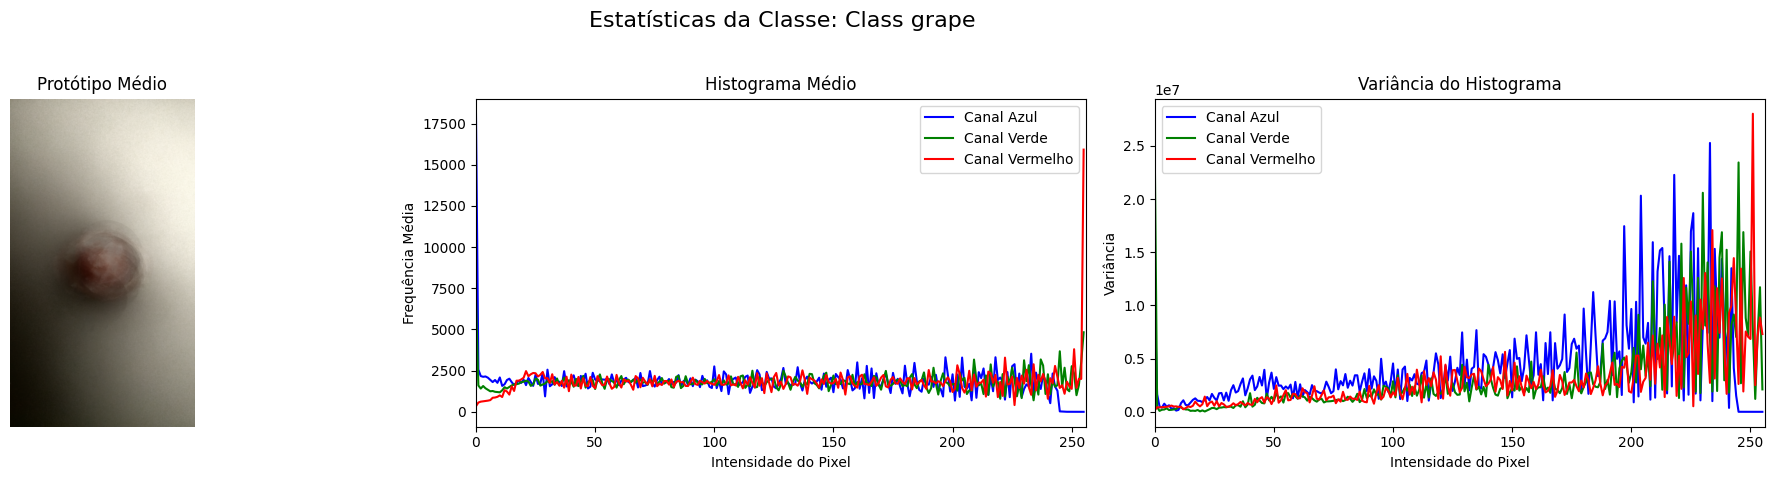

In [46]:
classes = {
    '0': 'banana',
    '1': 'pear',
    '2': 'poukan',
    '3': 'morgote',
    '4': 'persimmon',
    '5': 'lemon',
    '6': 'guava',
    '7': 'apple',
    '8': 'orange',
    '9': 'grape'
}
for i in range(10):
    p, h, v = calculate_class_statistics(os.path.join(OUTPUT_DIR), str(i))
    plot_results(f'Class {classes[str(i)]}', p, h, v)

Estatísticas do dataset original

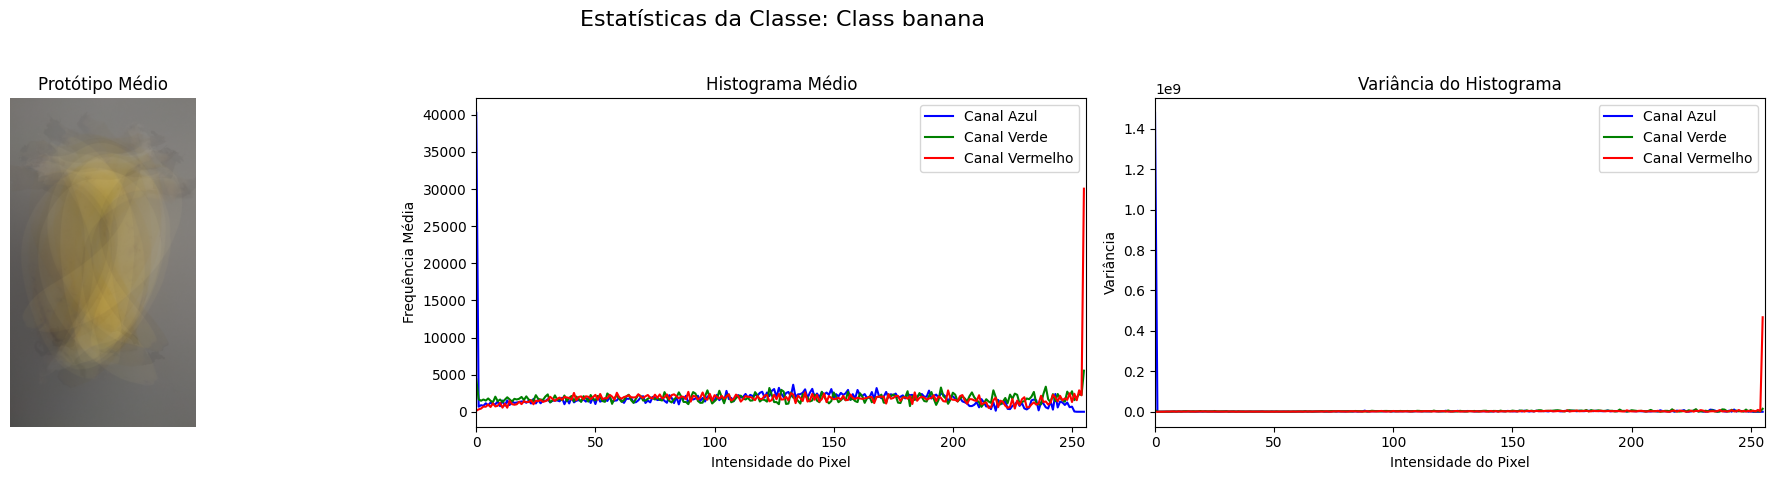

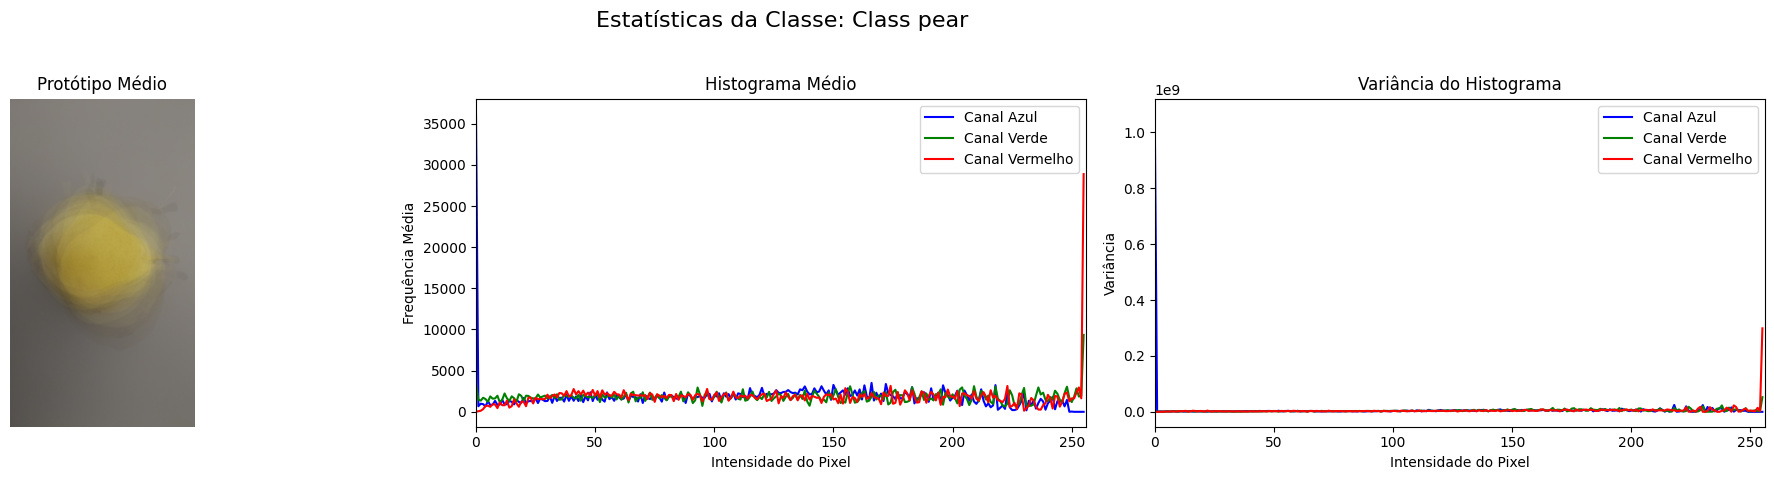

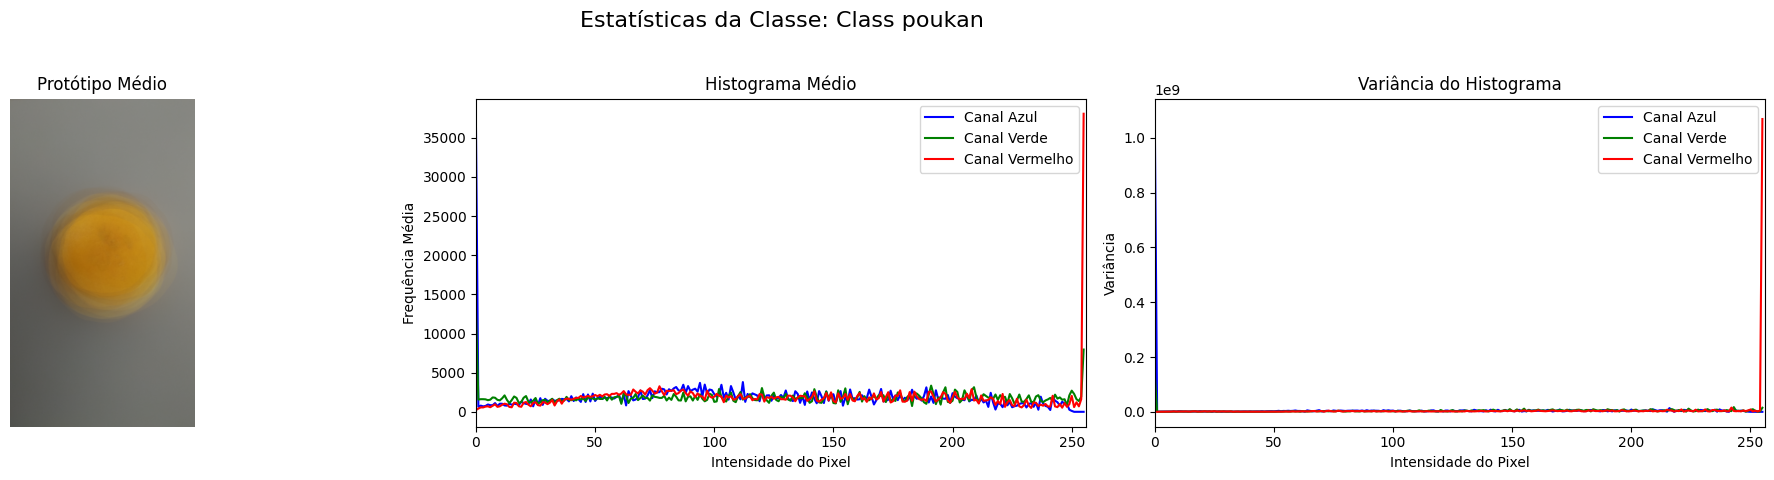

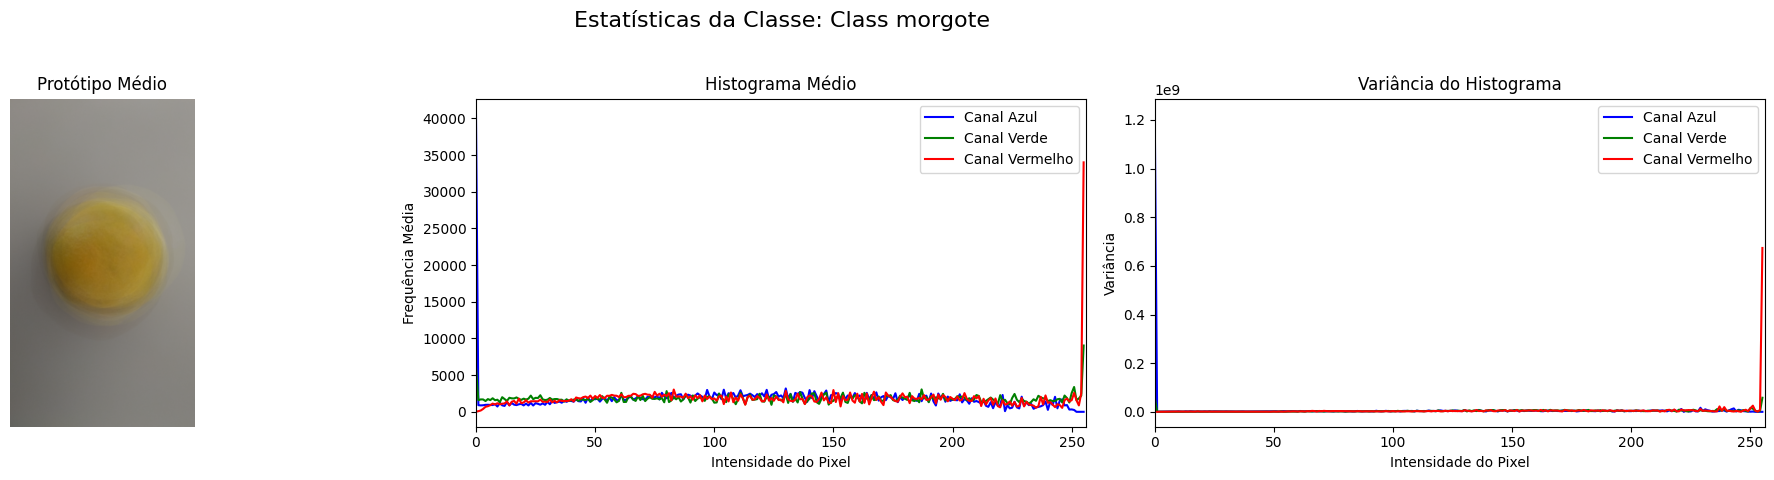

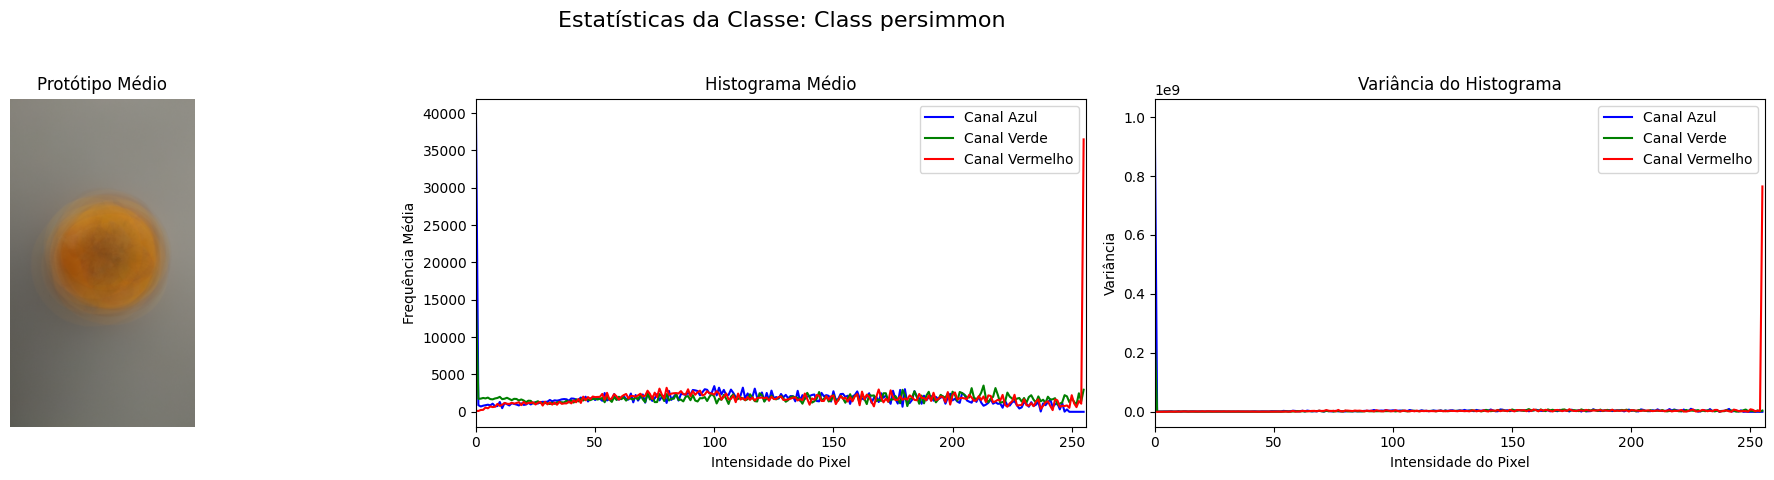

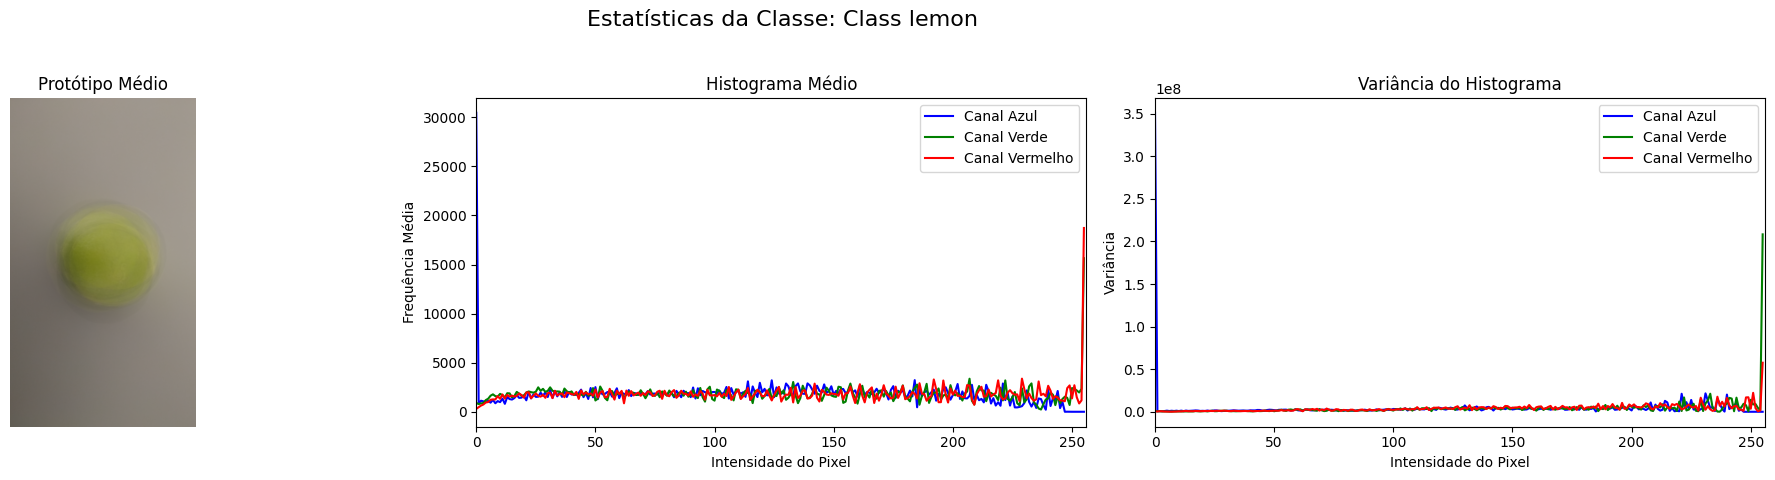

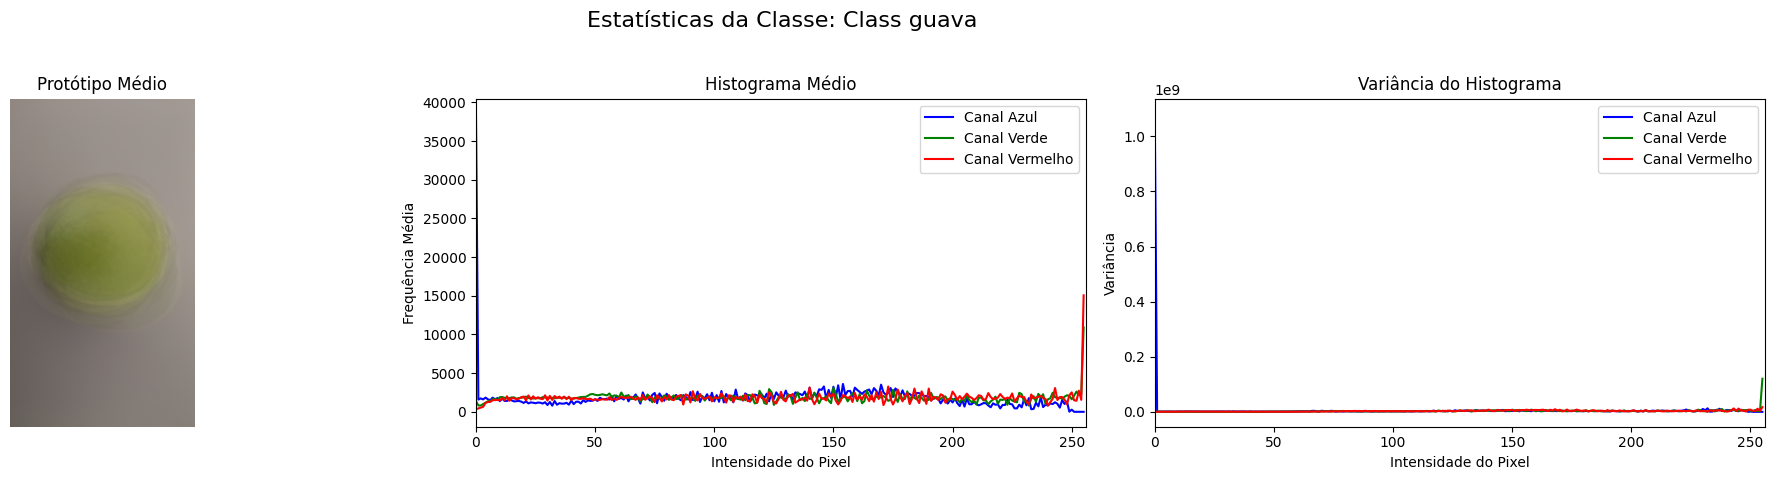

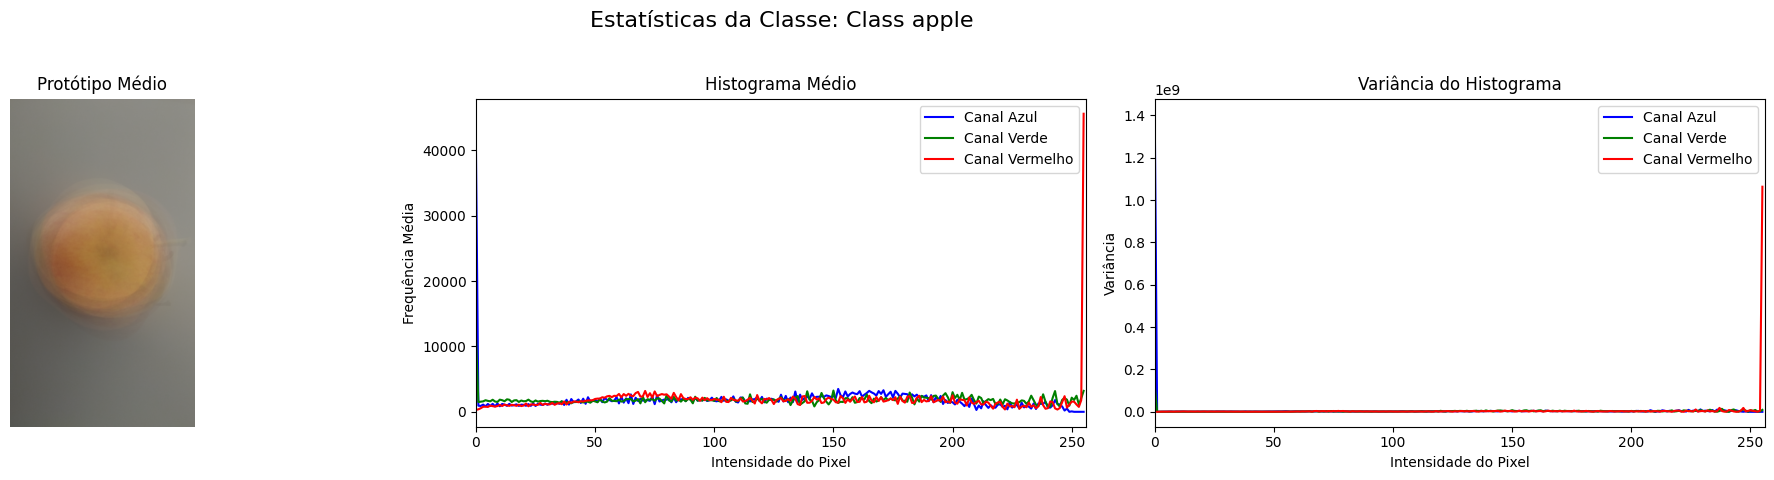

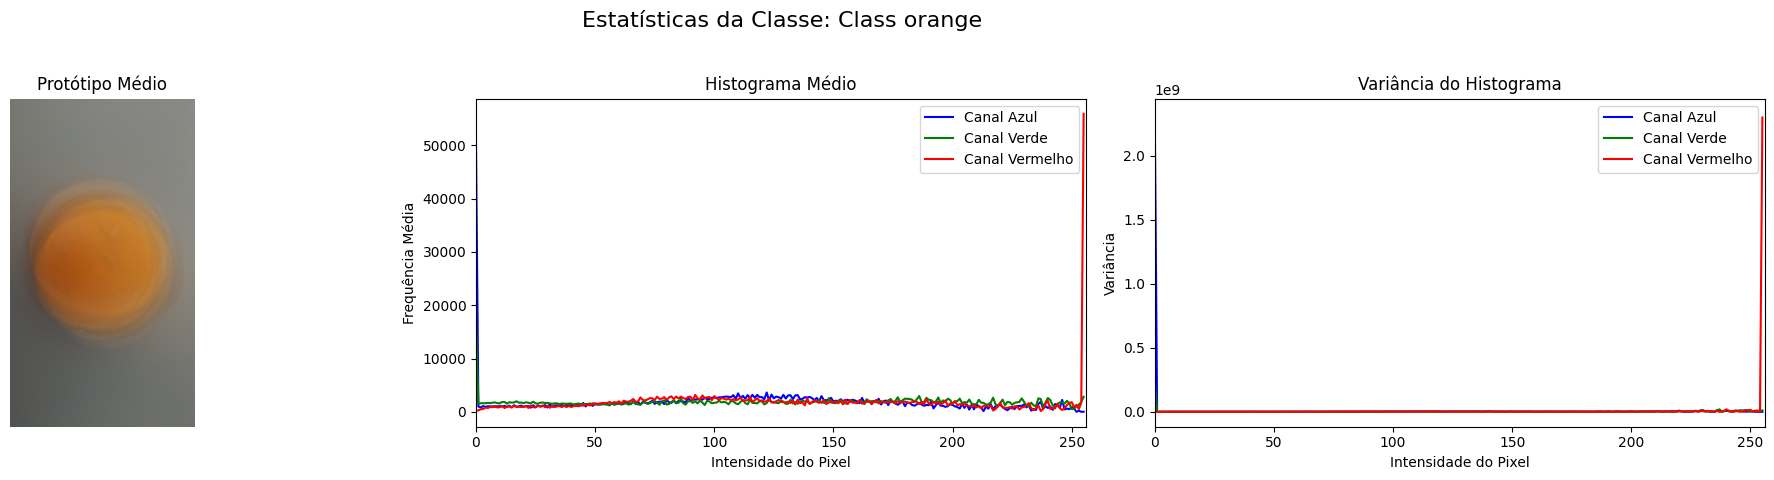

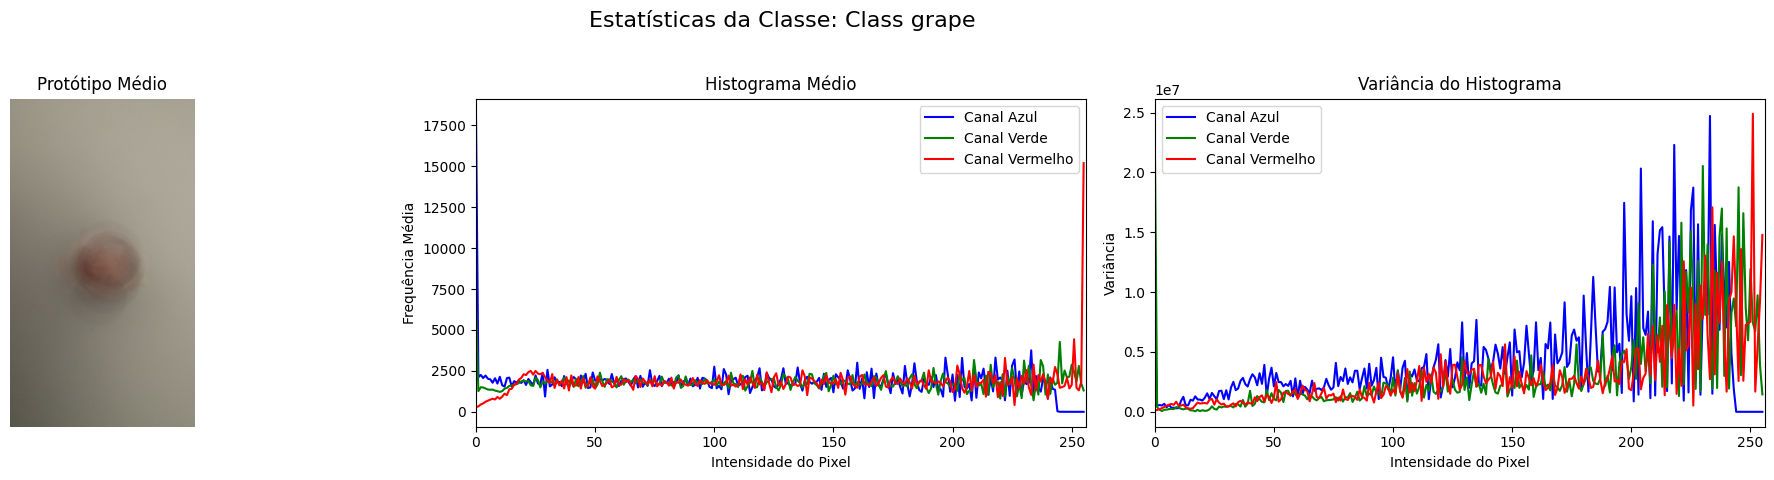

In [47]:
for i in range(10):
    p, h, v = calculate_class_statistics(os.path.join(BASE_DIR, 'images'), str(i))
    plot_results(f'Class {classes[str(i)]}', p, h, v)